In [1]:
import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

<Client: 'tcp://203.247.189.224:36654' processes=5 threads=90, memory=419.10 GiB>

# Load modules

In [2]:
# load public modules 

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp
import xcesm

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

cfg_var_TEMP=CESM2_config()
cfg_var_TEMP.year_s=1850
cfg_var_TEMP.year_e=2024
cfg_var_TEMP.setvar('TEMP')

In [5]:
cfg_var_photoC_TOT_zint_100m=CESM2_config()
cfg_var_photoC_TOT_zint_100m.year_s=1850
cfg_var_photoC_TOT_zint_100m.year_e=2024
cfg_var_photoC_TOT_zint_100m.setvar('photoC_TOT_zint_100m')

In [6]:
cut_grid_info = {
    "lonw": 210,
    "lone": 270,
    "lats": -20,
    "latn": 10
}

# Read files

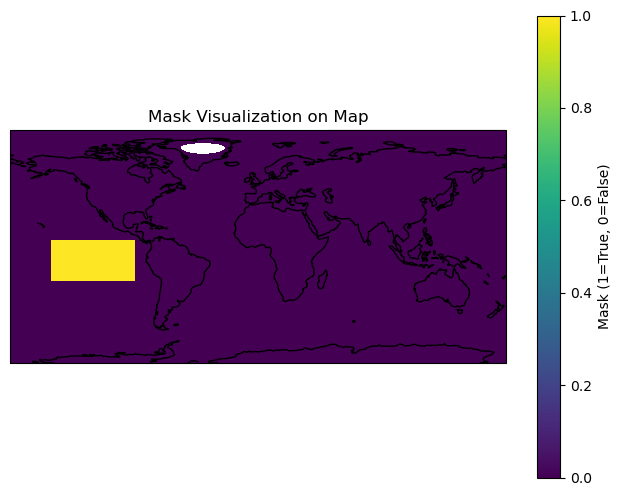

In [7]:
ds=ds_grid
mask = ((ds.TLONG >= cut_grid_info["lonw"]) 
        & (ds.TLONG <= cut_grid_info["lone"]) 
        & (ds.TLAT >= cut_grid_info["lats"]) 
        & (ds.TLAT <= cut_grid_info["latn"]))
iy, ix = np.where(mask)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8, 6))

# mask를 1/0으로 변환한 뒤 지도 위에 겹쳐서 표시
pc = ax.pcolormesh(ds.TLONG, ds.TLAT, mask.astype(int),
                   transform=ccrs.PlateCarree(),
                   cmap='viridis')

ax.coastlines()
plt.colorbar(pc, ax=ax, label='Mask (1=True, 0=False)')
plt.title('Mask Visualization on Map')
plt.show()

In [8]:
# define preprocessing function

ds_grid_sub = ds_grid.where(mask, drop=True)
area = ds_grid_sub['TAREA']
weighted_avg_manual = xr.Dataset()

# data = cfg_var_NO3.LE_ds['NO3']
# weighted_sum = (data * area).sum(dim=['nlat','nlon'], skipna=True)
# effective_area = area.where(data.notnull()).sum(dim=['nlat','nlon'], skipna=True)
# weighted_avg_manual['NO3'] = weighted_sum / effective_area



exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_TEMP.var, cfg_var_photoC_TOT_zint_100m.var]

def process_coords(varname, mask, ds_grid_sub, ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    # ds = ds.where(mask, drop=True)
    ds= ds.isel(z_t=slice(0, 1))
    ds= ds.isel(z_w=slice(0, 1))
   
    # volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # ds[varname] = weighted_sum / effective_volume
    
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        # ds= ds.mean(dim='time')
        return ds
    else:
        return ds.set_coords(coord_vars)


def process_coords_obs(ds, drop=True, except_coord_vars=['time','valid_time', 'lon','lat', 'TLONG', 'TLAT', 'sst', 'PP', 'sla', 'SOMXL030', 'NAV_LON', 'NAV_LAT', 'u10', 'v10']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    # ds = ds.where(mask, drop=True)
    # volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # ds[varname] = weighted_sum / effective_volume
    if 'valid_time' in ds:
        ds = ds.rename({'valid_time': 'time'})
    
    if drop:
        ds= ds.drop(coord_vars)
        return ds
    else:
        return ds.set_coords(coord_vars)

start_date = cftime.DatetimeNoLeap(cfg_var_TEMP.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_TEMP.year_e+1, 1, 1)

In [9]:
# Read LE dataset

start_time = time.time()

# TEMP
dname=cfg_var_TEMP.var
cfg_var_TEMP.LE_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.LE_ds = xr.open_mfdataset(cfg_var_TEMP.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, cftime.DatetimeNoLeap(1998, 2, 1), cftime.DatetimeNoLeap(2024, 1, 1)),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TEMP.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.LE_ds.time))
cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

elasped time for reading LE: 280.17490124702454


In [10]:
TEMP_ds_rgd=cfg_var_TEMP.LE_ds['TEMP'].mean(dim='time').utils.regrid()

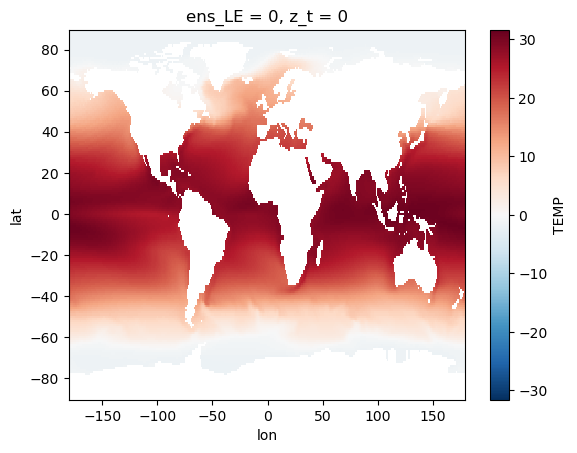

In [11]:
TEMP_ds_rgd.isel(ens_LE=0).isel(z_t=0).plot.pcolormesh()

In [12]:
# photoC_TOT_zint_100m
dname=cfg_var_photoC_TOT_zint_100m.var
cfg_var_photoC_TOT_zint_100m.LE_path_load(cfg_var_photoC_TOT_zint_100m.var)
cfg_var_photoC_TOT_zint_100m.LE_ds = xr.open_mfdataset(cfg_var_photoC_TOT_zint_100m.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_photoC_TOT_zint_100m.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, cftime.DatetimeNoLeap(1998, 2, 1), cftime.DatetimeNoLeap(2024, 1, 1)),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_photoC_TOT_zint_100m.LE_ds = cfg_var_photoC_TOT_zint_100m.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_photoC_TOT_zint_100m.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_photoC_TOT_zint_100m.LE_ds.time))
cfg_var_photoC_TOT_zint_100m.LE_ds = cfg_var_photoC_TOT_zint_100m.LE_ds.assign_coords(time=new_time)


In [13]:
photoC_TOT_zint_100m_ds_rgd=cfg_var_photoC_TOT_zint_100m.LE_ds['photoC_TOT_zint_100m'].mean(dim='time').utils.regrid()

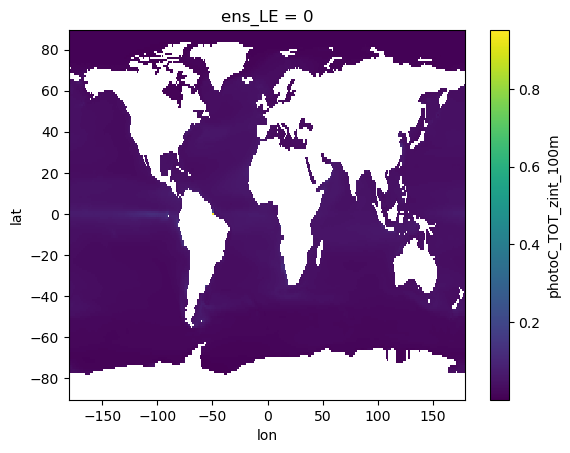

In [14]:
photoC_TOT_zint_100m_ds_rgd.isel(ens_LE=0).plot.pcolormesh()

In [15]:
# Read Observation dataset (TEMP)
start_time = time.time()

# TEMP
cfg_var_TEMP.OBS_path_load(cfg_var_TEMP.var)
dname=cfg_var_TEMP.OBS_var
cfg_var_TEMP.OBS_ds = xr.open_mfdataset(
    cfg_var_TEMP.OBS_file_list[0][0],
    chunks={'time': 12},
    parallel=True,
    preprocess=lambda ds: process_coords_obs(ds),
    combine="by_coords",
    decode_times=True,  # skip calendar/time decoding
)

cfg_var_TEMP.OBS_ds = cfg_var_TEMP.OBS_ds.rename({cfg_var_TEMP.OBS_var: cfg_var_TEMP.var})

cfg_var_TEMP.OBS_ds= cfg_var_TEMP.OBS_ds.sel( time=slice(datetime.datetime(1998, 1, 1), datetime.datetime(2023, 12, 31)))


end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))

elasped time for reading OBS: 155.69417548179626


In [16]:
# Read Observation dataset (NPP)
start_time = time.time()
# photoC_TOT_zint_100m
cfg_var_photoC_TOT_zint_100m.OBS_path_load(cfg_var_photoC_TOT_zint_100m.var)
dname=cfg_var_photoC_TOT_zint_100m.OBS_var
cfg_var_photoC_TOT_zint_100m.OBS_ds = xr.open_mfdataset(
    cfg_var_photoC_TOT_zint_100m.OBS_file_list[0][0],
    chunks={'time': 12},
    parallel=True,
    preprocess=lambda ds: process_coords_obs(ds),
    combine="by_coords",
    decode_times=True,  # skip calendar/time decoding
)

cfg_var_photoC_TOT_zint_100m.OBS_ds = cfg_var_photoC_TOT_zint_100m.OBS_ds.rename({cfg_var_photoC_TOT_zint_100m.OBS_var: cfg_var_photoC_TOT_zint_100m.var})
cfg_var_photoC_TOT_zint_100m.OBS_ds.time

cfg_var_photoC_TOT_zint_100m.OBS_ds= cfg_var_photoC_TOT_zint_100m.OBS_ds.sel( time=slice(datetime.datetime(1998, 1, 1), datetime.datetime(2023, 12, 31)))

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))


elasped time for reading OBS: 27.897693634033203


In [17]:
OBS_photoC_TOT_zint_100m_ds_rgd=cfg_var_photoC_TOT_zint_100m.OBS_ds['photoC_TOT_zint_100m'].mean(dim='time').utils.regrid()

In [18]:
OBS_TEMP_ds_rgd=cfg_var_TEMP.OBS_ds['TEMP'].mean(dim='time').utils.regrid()

In [19]:
TEMP_ds_rgd

<xarray.DataArray 'TEMP' (ens_LE: 50, z_t: 1, lat: 180, lon: 360)> Size: 13MB
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [-1.6800812, -1.6818409, -1.6818409, ..., -1.6796445,
          -1.6796445, -1.6800812],
         [-1.6816807, -1.6816807, -1.6816807, ..., -1.6816807,
          -1.6816807, -1.6816807],
         [-1.6821831, -1.6821831, -1.6821831, ..., -1.6821831,
          -1.6821831, -1.6821831]]],


       [[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
...
          -1.703601 , -1.7039343],
         [-1.708696 , -1.708696 , -1.708696 , ..., -1.708696 ,
          -1.708696 , -1.708696 ],
         [-1.7103299, -1.7103299, -1.7103299, ..., -1.7103299,
          -1.7103299, -1.7103299]]],


       [[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [-1.6970749, -1.7001202, -1.7001202, ..., -1.6969675,
          -1.6969675, -1.6970749],
         [-1.7018217, -1.7018217, -1.7018217, ..., -1.7018217,
          -1.7018217, -1.7018217],
         [-1.7033944, -1.7033944, -1.7033944, ..., -1.7033944,
          -1.7033944, -1.7033944]]]], dtype=float32)
Coordinates:
  * ens_LE   (ens_LE) int64 400B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * z_t      (z_t) int64 8B 0
  * lat      (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float64 3kB -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0

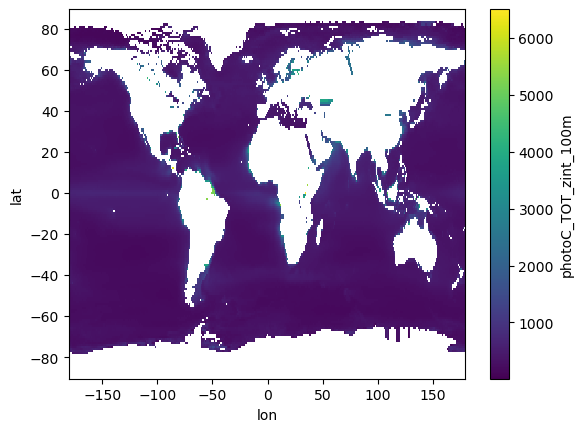

In [20]:
OBS_photoC_TOT_zint_100m_ds_rgd.plot.pcolormesh()

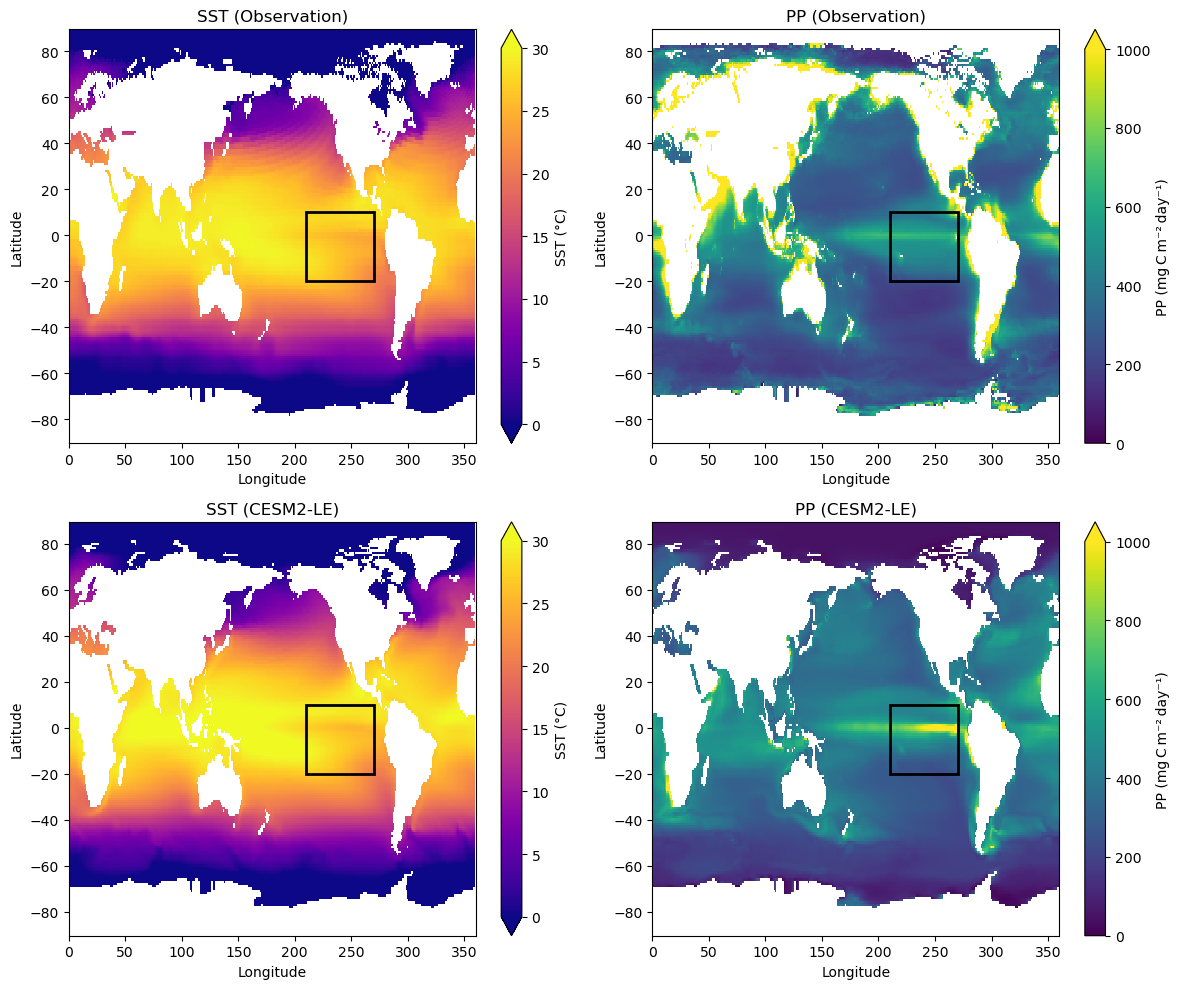

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import numpy as np

# === Observation Data ===
lon = OBS_photoC_TOT_zint_100m_ds_rgd['lon'].values
lat = OBS_photoC_TOT_zint_100m_ds_rgd['lat'].values
data_npp_obs = OBS_photoC_TOT_zint_100m_ds_rgd.values
data_temp_obs = OBS_TEMP_ds_rgd.values

# Convert longitude to 0~360 and sort
lon2 = np.where(lon < 0, lon + 360, lon)
sorted_idx = np.argsort(lon2)
lon_sorted = lon2[sorted_idx]
data_npp_obs_sorted = data_npp_obs[:, sorted_idx]
data_temp_obs_sorted = data_temp_obs[:, sorted_idx]

# === CESM2-LE Data ===
data_npp_cesm = photoC_TOT_zint_100m_ds_rgd.isel(ens_LE=0).values
data_temp_cesm = TEMP_ds_rgd.isel(z_t=0).isel(ens_LE=0).values
data_npp_cesm_sorted = data_npp_cesm[:, sorted_idx]
data_temp_cesm_sorted = data_temp_cesm[:, sorted_idx]

# === Figure Setup ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# === (1,1) Observation Temperature ===
ax = axes[0, 0]
temp_levels = np.linspace(0, 30, 11)
norm_temp = mcolors.BoundaryNorm(temp_levels, ncolors=len(temp_levels)-1, clip=False)

pc = ax.pcolormesh(lon_sorted, lat, data_temp_obs_sorted, shading='auto', cmap='plasma', vmin=0, vmax=30)
fig.colorbar(pc, ax=ax, orientation='vertical', extend='both').set_label('SST (°C)')

rect = patches.Rectangle((210, -20), 60, 30, linewidth=2, edgecolor='black', facecolor='none', zorder=3)
ax.add_patch(rect)
ax.set_title('SST (Observation)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(0, 360)

# # === (1,2) Observation NPP ===
ax = axes[0, 1]
npp_levels = np.linspace(0, 1000, 11)
norm_npp = mcolors.BoundaryNorm(npp_levels, ncolors=len(npp_levels)-1, clip=False)

pc = ax.pcolormesh(lon_sorted, lat, data_npp_obs_sorted, shading='auto', cmap='viridis', vmin=0, vmax=1000)
fig.colorbar(pc, ax=ax, orientation='vertical', extend='max').set_label('PP (mg C m⁻² day⁻¹)')

rect = patches.Rectangle((210, -20), 60, 30, linewidth=2, edgecolor='black', facecolor='none', zorder=3)
ax.add_patch(rect)
ax.set_title('PP (Observation)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(0, 360)

# === (2,1) CESM2-LE Temperature ===
ax = axes[1, 0]
pc = ax.pcolormesh(lon_sorted, lat, data_temp_cesm_sorted, shading='auto', cmap='plasma', vmin=0, vmax=30)
# pc = ax.pcolormesh(lon_sorted, lat, data_temp_cesm_sorted, shading='auto', cmap='plasma')
fig.colorbar(pc, ax=ax, orientation='vertical', extend='both').set_label('SST (°C)')

rect = patches.Rectangle((210, -20), 60, 30, linewidth=2, edgecolor='black', facecolor='none', zorder=3)
ax.add_patch(rect)
ax.set_title('SST (CESM2-LE)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(0, 360)

# # === (2,2) CESM2-LE NPP ===
# Conversion: nmol → mol → g → mg, cm² → m², s → day
# Total factor = 1e4 (cm²→m²) × 86,400 (s→day) × 1e-9 (nmol→mol) × 12,000 (mol C→mg C) = 10,368

ax = axes[1, 1]
pc = ax.pcolormesh(lon_sorted, lat, data_npp_cesm_sorted*10368, shading='auto', cmap='viridis', vmin=0, vmax=1000)
fig.colorbar(pc, ax=ax, orientation='vertical', extend='max').set_label('PP (mg C m⁻² day⁻¹)')

rect = patches.Rectangle((210, -20), 60, 30, linewidth=2, edgecolor='black', facecolor='none', zorder=3)
ax.add_patch(rect)
ax.set_title('PP (CESM2-LE)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(0, 360)

plt.tight_layout()
plt.show()


In [22]:
print('SST (Observation): min', np.nanmin(data_temp_obs_sorted), 'max', np.nanmax(data_temp_obs_sorted))
print('NPP (Observation): min', np.nanmin(data_npp_obs_sorted), 'max', np.nanmax(data_npp_obs_sorted))

print('SST (CESM2-LE): min', np.nanmin(data_temp_cesm_sorted), 'max', np.nanmax(data_temp_cesm_sorted))
print('NPP (CESM2-LE): min', np.nanmin(data_npp_cesm_sorted), 'max', np.nanmax(data_npp_cesm_sorted))


SST (Observation): min -721.65106 max 29.847584
NPP (Observation): min 12.65176 max 6500.8643
SST (CESM2-LE): min -1.8836005 max 31.602968
NPP (CESM2-LE): min 3.097049e-05 max 0.9516531


In [23]:
data_npp_obs_sorted

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [24]:
norm_temp